In [1]:
from bs4 import BeautifulSoup
from retrieve_train_wf import get_training_labels
from get_blobs import get_blob
from google.cloud import storage

import gcsfs  ## Google Cloud Storage file system
import os
import pandas as pd
import requests
import tarfile
import wfdb
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def fetch_settings():
    return {
        'fetch_clinical_data': False,
        'verbose': False,
        'google_cloud': {
            'project': "qwiklabs-gcp-04-133e595cc3fe"
        }
    }

In [3]:
fs = gcsfs.GCSFileSystem(project="qwiklabs-gcp-04-133e595cc3fe")
bucket_name = 'physionet_2009'
fs.ls(bucket_name)

['physionet_2009/mimic2cdb',
 'physionet_2009/test-set-a',
 'physionet_2009/test-set-b',
 'physionet_2009/train_wave']

Grab Data from GCP

In [5]:
training = get_training_labels()
record_map = pd.read_csv(
    fs.open(f'{bucket_name}/mimic2cdb/MAP', 'rb'),
    sep="\t", 
    names = ['Clinical', 'Wave', 'Sex', 'Age', 'Birthdate', 'Waveform'],
    index_col = False, 
    skiprows = [0,1])
record_map = record_map[record_map['Wave'].isin(training.keys())]

In [6]:
record_map.head()

,Clinical,Wave,Sex,Age,Birthdate,Waveform
27,s00318,a40802,M,58,11/10/1950,14/07/2009
38,s00439,a40064,F,82,22/12/1930,13/01/2013
217,s02172,a40099,M,32,07/07/1982,20/10/2014
234,s02280,a41664,M,58,04/07/1957,19/01/2016
243,s02395,a40006,F,80,30/03/1931,02/06/2011


In [7]:
def generate_record_map():
    settings = fetch_settings()
    df = pd.read_csv(
        fs.open(f'{bucket_name}/mimic2cdb/MAP', 'rb'),
        sep="\t", 
        names = ['Clinical', 'Wave', 'Sex', 'Age', 'Birthdate', 'Waveform'],
        index_col = False, 
        skiprows = [0,1])
    df = df[df['Wave'].isin(training.keys())]
    if settings['verbose']:
        print(f"Dimensions of data set: {df.shape}")
        print(f"Data set reflects data for {len(df['Clinical'].unique().tolist())} clinical IDs")
        print(f"Data set reflects data for {len(df['Wave'].unique().tolist())} waveform IDs")
    return({'data':df, 
            'clinical_entities': df['Clinical'].unique().tolist(),
            'waveform_entities': df['Wave'].unique().tolist()
           })

def filter_data_to_entity(df, entity_colname, entity):
    return df[df[entity_colname] == entity]


def generate_waveform_dataset(e, df):
    settings = fetch_settings()
    data = filter_data_to_entity(df, 'Wave', e)
    print(data)
    data = data.squeeze().to_dict()
    result = {'raw_data': data}
    
    if settings['verbose']:
        print(data)

    print("Retrieving data from GCP")
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blobs = [i for i in bucket.list_blobs() if data['Wave'] in i.name]
    for blob in blobs:
        get_blob(bucket, blob, f"data/train_wave/{blob.name.split('/')[-1]}")
     
    print("Copy from GCP done... ")
    record = wfdb.rdrecord(f"data/train_wave/{data['Wave']}")
    return {
        'raw_data': data,
        'waveform_record': record.__dict__
    }

In [8]:
record_map = generate_record_map()

## Generate the Dataset

In [9]:
x = {e: generate_waveform_dataset(e, record_map['data']) for e in record_map['waveform_entities'][0:5]}
x.keys()

   Clinical    Wave Sex Age   Birthdate    Waveform
27   s00318  a40802   M  58  11/10/1950  14/07/2009
Retrieving data from GCP
Copy from GCP done... 
   Clinical    Wave Sex Age   Birthdate    Waveform
38   s00439  a40064   F  82  22/12/1930  13/01/2013
Retrieving data from GCP
Copy from GCP done... 
    Clinical    Wave Sex Age   Birthdate    Waveform
217   s02172  a40099   M  32  07/07/1982  20/10/2014
Retrieving data from GCP
Copy from GCP done... 
    Clinical    Wave Sex Age   Birthdate    Waveform
234   s02280  a41664   M  58  04/07/1957  19/01/2016
Retrieving data from GCP
Copy from GCP done... 
    Clinical    Wave Sex Age   Birthdate    Waveform
243   s02395  a40006   F  80  30/03/1931  02/06/2011
Retrieving data from GCP
Copy from GCP done... 


dict_keys(['a40802', 'a40064', 'a40099', 'a41664', 'a40006'])

Int64Index([2447442, 2447443, 2447444, 2447445, 2447446, 2447447, 2447448,
            2447449, 2447450, 2447451,
            ...
            2447932, 2447933, 2447934, 2447935, 2447936, 2447937, 2447938,
            2447939, 2447940, 2447941],
           dtype='int64', length=500)
AxesSubplot(0.125,0.125;0.775x0.755)


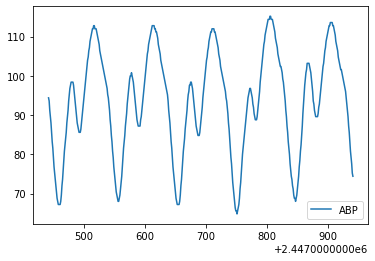

In [111]:
#record = x['a40802']['waveform_record']
df = pd.DataFrame(record['p_signal'], columns = record['sig_name'])
df = df[~df['ABP'].isna()]
window = df[['ABP']].iloc[1419500:1420000]
print(window.index)
window = window.reset_index()

## Think we're isolating an arterial waveform show systolic and diastolic pressure
## as well as dicrotic notch
print(df[['ABP']].iloc[1419500:1420000].plot())

In [112]:
def scaler(abp):
    mins = min(abp)
    maxs = max(abp)
    
    num = abp - mins
    den = maxs - mins
    
    scaled = (2*num/den) - 1
    
    return scaled

scaled = scaler(window.values[:,1])

In [113]:
window.index *= 0.008

(50.0, 200.0)

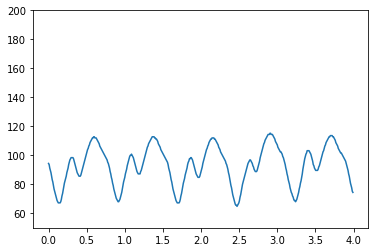

In [181]:
plt.plot(window.index, window.values[:,1])
plt.ylim((50, 200))

(0.0, 5.0)

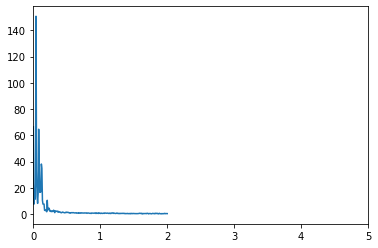

In [115]:
from scipy.fft import fft, fftfreq
from numpy.fft import rfft

N = len(window)
x_values = window.index

#yf = np.abs(rfft(window.values[:,1]))
yf = np.abs(rfft(scaled))

fig, ax = plt.subplots()
ax.plot(x_values[0:N//2+1], yf)
ax.set_xlim((0, 5))
#ax.set_ylim((0, 2.5))
#ax.set_xticks(np.arange(0, 50, step=5))

In [164]:
import ewtpy

ewt, mfb, boundaries = ewtpy.EWT1D(window.values[:,1], N=3,)

In [165]:
ewt.shape

(500, 3)

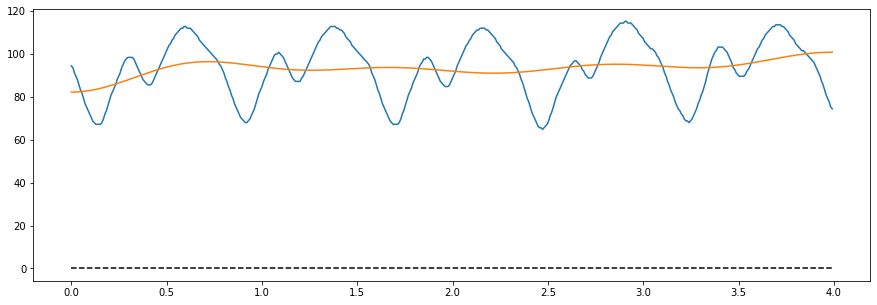

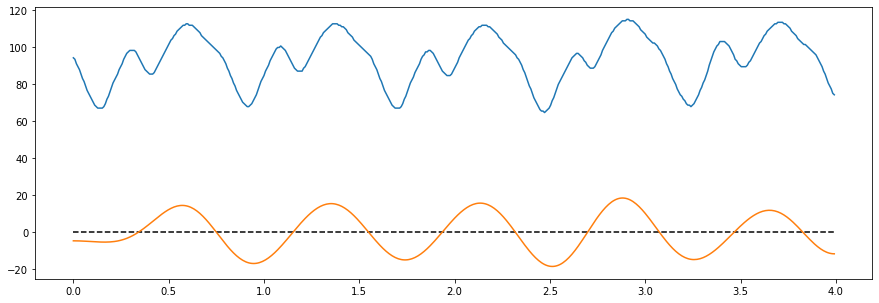

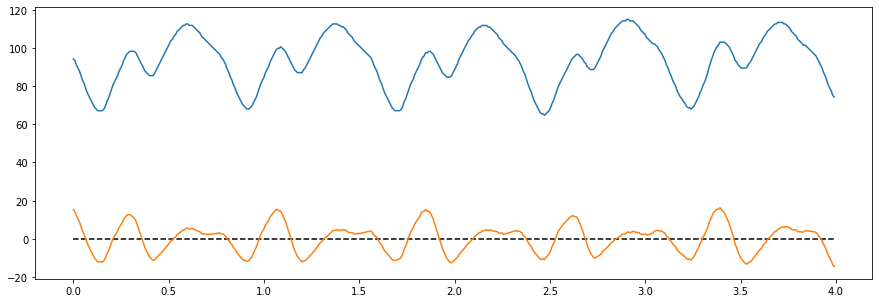

In [168]:
for i in range(3):
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.plot(x_values, np.zeros(len(scaled)), ls='--', color='k')
    plt.plot(x_values, window.values[:,1])
    plt.plot(x_values, ewt[:,i])

# Plot the first order difference

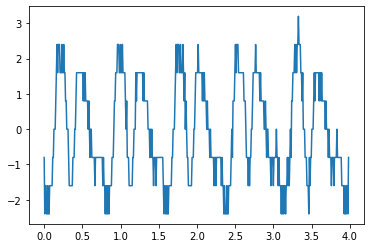

In [179]:
from scipy.signal import savgol_filter
plt.plot(x_values[:-1], np.diff(window.values[:,1]))

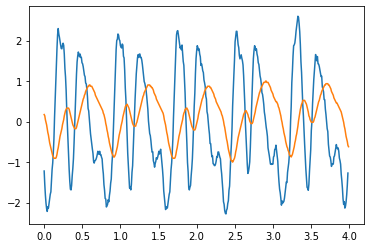

In [180]:
plt.plot(x_values[:-1], savgol_filter(np.diff(window.values[:,1]), 11, 2))
plt.plot(x_values, scaled)